# **TUTORIAL: analyze and classify sounds with AI**

*A guide to analyze and classify marine mammal sounds.*

## Introduction

Audio or sound classification is a technique with multiple applications in the field of AI and data science.

Use cases:
- chatbots
- automated speech translators
- virtual assistants
- music genre identification 
- text-to-speech applications
- ...

Audio classifications come in many types and forms, such as classification of acoustic data, music, natural language and environmental sounds.

## Objective

The aim of this Notebook is to use **AI NOTEBOOKS** product to train a model to **classify marine mammal sounds**.

Here, the sounds in the dataset are in `.wav` format. 

To use them and obtain results you have to pre-process this data by following different steps.

- Analyse one of these audio recordings
- Transform each sound file into a `.csv` file
- Train your model from the `.csv` file

**USE CASE:** [Best of Watkins Marine Mammal Sound Database](https://www.kaggle.com/shreyj1729/best-of-watkins-marine-mammal-sound-database/version/3)

![](./assets/categories.png)

This dataset is composed of **55 different folders** corresponding to the marine mammals. In each folder are stored several sound files of each animal.

You can get more information about this dataset on this [website](https://cis.whoi.edu/science/B/whalesounds/index.cfm).

The data distribution is as follows:

![](./assets/data.png)

#### ⚠️ *For this example, we choose only the first 45 classes (or folders).*

Let’s follow the different steps!

![](./assets/plan.png)


## Step 1 - Import dependencies

In [1]:
# audio libraries
import librosa
import librosa.display as lplt
import IPython

# import matplotlib to be able to display graphs
import matplotlib.pyplot as plt

# transform .wav into .csv
import csv
import os
import numpy as np
import pandas as pd

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# model
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential


## Step 2 - Audio libraries

### 1. Loading an audio file with Librosa

**Librosa**: Python module for audio signal analysis. 

By using **Librosa**, you can extract key features from the audio samples:
- Tempo
- Chroma Energy Normalized
- Mel-Freqency Cepstral Coefficients
- Spectral Centroid, Spectral Contrast 
- Spectral Rolloff
- Zero Crossing Rate

If you want to know more about this library, refer to the [documentation](https://librosa.org/doc/latest/index.html).

You can start by looking at your data by displaying different parameters using the **Librosa** library.

First, you can do a test on a file.

In [2]:
test_sound = "/workspace/data/AtlanticSpottedDolphin/61025001.wav"

Loads and decodes the audio.

In [3]:
data, sr = librosa.load(test_sound)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [4]:
librosa.load(test_sound ,sr = 45600)

(array([-0.0739522 , -0.06588229, -0.06673266, ...,  0.03021295,
         0.05592792,  0.        ], dtype=float32),
 45600)

### 2. Playing Audio with IPython.display.Audio

[IPython.display.Audio](https://ipython.org/ipython-doc/stable/api/generated/IPython.display.html#IPython.display.Audio) advises you play audio directly in a **Jupyter notebook**.

Using **IPython.display.Audio** to play the audio.

In [5]:
IPython.display.Audio(data, rate = sr)

## Step 3 - Visualizing Audio

### 1. Waveforms

**Waveforms**: visual representations of sound as time on the x-axis and amplitude on the y-axis. They allow for quick analysis of audio data.

You can display the audio array using **librosa.display.waveplot**.

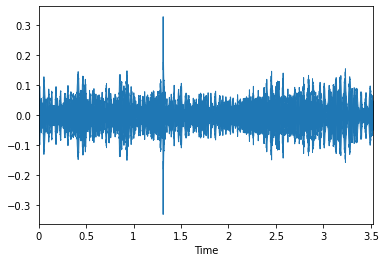

In [6]:
plt.show(librosa.display.waveplot(data))

### 2. Spectrograms

**Spectrogram**: visual way of representing the intensity of a signal over time at various frequencies present in a particular waveform.
> Some warnings can appear, don't be afraid, you can execute the next steps of the notebook

/opt/conda/lib/python3.7/site-packages/librosa/display.py:823: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


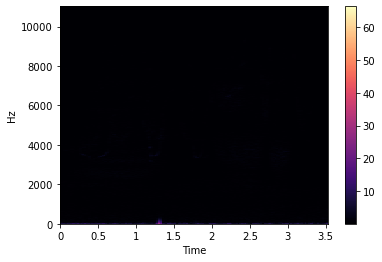

In [7]:
stft = librosa.stft(data)
plt.colorbar(librosa.display.specshow(stft, sr = sr, x_axis = 'time', y_axis = 'hz'))

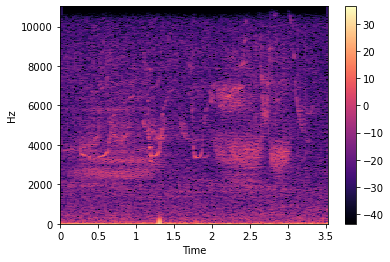

In [8]:
stft_db = librosa.amplitude_to_db(abs(stft))
plt.colorbar(librosa.display.specshow(stft_db, sr = sr, x_axis = 'time', y_axis = 'hz'))

### 3. Spectral Rolloff

**Spectral Rolloff**: frequency below which a specified percentage of the total spectral energy.

**librosa.feature.spectral_rolloff** calculates the attenuation frequency for each frame of a signal.

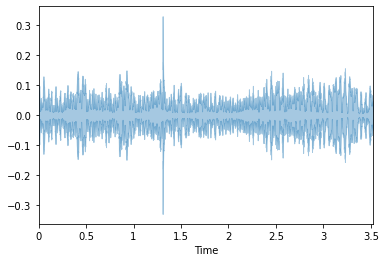

In [9]:
spectral_rolloff = librosa.feature.spectral_rolloff(data + 0.01, sr = sr)[0]
plt.show(librosa.display.waveplot(data, sr = sr, alpha = 0.4))

### 4. Chroma Feature

This tool is perfect for analyzing musical features whose pitches can be meaningfully categorized and whose tuning is close to the equal temperament scale.

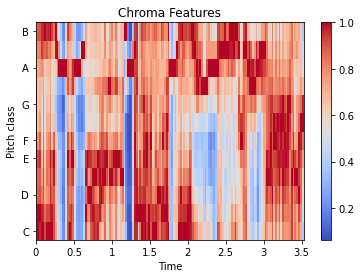

In [10]:
chroma = librosa.feature.chroma_stft(data, sr = sr)
lplt.specshow(chroma, sr = sr, x_axis = "time" ,y_axis = "chroma", cmap = "coolwarm")
plt.colorbar()
plt.title("Chroma Features")
plt.show()

### 5. Zero Crossing Rate

**Zero crossing**: occurs if successive samples have different algebraic signs.

- The rate at which zero crossings occur is a simple measure of the frequency content of a signal.
- The number of zero-crossings measures the number of times in a time interval that the amplitude of speech signals passes through a zero value.

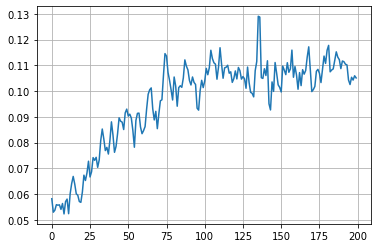

In [11]:
start = 1000
end = 1200
plt.plot(data[start:end])
plt.grid()

## Step 4 - Data preprocessing

### 1. Data transformation

To train your model, preprocessing of data is required. First of all, you have to convert the `.wav` into a `.csv` file.

- Define columns name:

In [41]:
header = "filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean \
        spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var harmony_mean harmony_var perceptr_mean \
        perceptr_var tempo mfcc1_mean mfcc1_var mfcc2_mean mfcc2_var mfcc3_mean mfcc3_var mfcc4_mean mfcc4_var label".split()

- Create the `data.csv` file:

In [13]:
file = open("data.csv", "w", newline = "")
with file:
    writer = csv.writer(file)
    writer.writerow(header)

- Define character string of marine mammals (45):

There are 45 different marine animals, or 45 classes.

In [14]:
marine_mammals = "AtlanticSpottedDolphin BeardedSeal Beluga_WhiteWhale BlueWhale BottlenoseDolphin Boutu_AmazonRiverDolphin BowheadWhale ClymeneDolphin \
        Commerson'sDolphin CommonDolphin Dall'sPorpoise DuskyDolphin FalseKillerWhale Fin_FinbackWhale FinlessPorpoise Fraser'sDolphin Grampus_Risso'sDolphin \
        GraySeal GrayWhale HarborPorpoise HarbourSeal HarpSeal Heaviside'sDolphin HoodedSeal HumpbackWhale IrawaddyDolphin JuanFernandezFurSeal KillerWhale \
        LeopardSeal Long_FinnedPilotWhale LongBeaked(Pacific)CommonDolphin MelonHeadedWhale MinkeWhale Narwhal NewZealandFurSeal NorthernRightWhale \
        PantropicalSpottedDolphin RibbonSeal RingedSeal RossSeal Rough_ToothedDolphin SeaOtter Short_Finned(Pacific)PilotWhale SouthernRightWhale SpermWhale".split()

- Transform each `.wav` file into a `.csv` row:
> Some warnings can appear, don't be afraid, you can execute the next steps of the notebook
>
> This step can be very long.

In [ ]:
for animal in marine_mammals:

    for filename in os.listdir(f"/workspace/data/{animal}/"):

        sound_name = f"/workspace/data/{animal}/{filename}"
        y, sr = librosa.load(sound_name, mono = True, duration = 30)
        chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
        rmse = librosa.feature.rms(y = y)
        spec_cent = librosa.feature.spectral_centroid(y = y, sr = sr)
        spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr)
        rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y = y, sr = sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'

        for e in mfcc:
            to_append += f' {np.mean(e)}'

        to_append += f' {animal}'
        file = open('data.csv', 'a', newline = '')

        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

- Display the `data.csv` file:

In [16]:
df = pd.read_csv('data.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,label
0,6102603E.wav,0.426664,0.042434,5157.104325,3101.100191,8617.587891,0.356964,-241.481033,24.920166,48.238968,...,13.670743,-0.705876,12.712521,1.321301,10.524447,0.343317,6.712308,0.371731,1.841404,AtlanticSpottedDolphin
1,61026030.wav,0.434773,0.053204,5594.399169,2860.406861,8655.933556,0.434289,-228.107635,-4.825935,60.204544,...,11.302414,2.397469,13.868607,-2.265396,11.323673,0.582180,6.923624,-2.080763,1.947379,AtlanticSpottedDolphin
2,61026048.wav,0.432415,0.042047,5135.238139,2982.555668,8378.181032,0.365667,-244.113342,12.709079,48.617630,...,15.568404,-2.544822,10.559988,-0.473371,8.464706,0.382612,6.677320,2.163096,3.520124,AtlanticSpottedDolphin
3,6102603I.wav,0.438314,0.076127,5803.472083,3099.706089,9038.656456,0.414833,-198.311844,0.518129,47.096676,...,15.731695,0.987929,16.382414,-0.967779,8.810925,1.867840,9.033828,2.434472,3.793100,AtlanticSpottedDolphin
4,61026047.wav,0.416906,0.081022,5043.428899,2982.812198,8271.866648,0.322625,-234.926605,12.705063,54.443558,...,15.146926,1.311773,13.756646,-0.811321,8.872554,3.451088,6.508763,-0.489402,4.719871,AtlanticSpottedDolphin


In [17]:
# dataframe shape
df.shape

(12565, 28)

In [18]:
# dataframe types
df.dtypes

filename                    object
length                     float64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
label                       object
dtype: object

### 2. Features extraction

In the preprocessing of the data, **feature extraction** is necessary before running the training. The purpose is to define the **inputs** and **outputs** of the neural network.

- **OUTPUT** (y): last column which is the `label`.

You cannot use text directly for training. You have encode these labels with the **LabelEncoder()** function of **sklearn.preprocessing**.

So, before running run a model, convert this type of categorical text data into numerical data that the model can understand.

In [19]:
class_list = df.iloc[:,-1]
encoder = LabelEncoder()
y = encoder.fit_transform(class_list)
print("y: ", y)

y:  [ 0  0  0 ... 44 44 44]


- **INPUTS** (X): all other columns are input parameters of the neural network except the `filename`.

You remove the first column which does not provide any information for the training (the filename) and the last one which corresponds to the output.

In [20]:
input_parameters = df.iloc[:, 1:27]
scaler = StandardScaler()
X = scaler.fit_transform(np.array(input_parameters))
print("X:", X)

X: [[-0.71758759  0.20419758  1.17840861 ...  0.59678504  0.59680033
  -0.43635211]
 [-0.66140594  0.48716815  1.44344394 ...  0.6360472   0.11020783
  -0.41656124]
 [-0.67774188  0.19402336  1.16515597 ...  0.59028425  0.95222009
  -0.12285259]
 ...
 [-1.00584499  1.27000953  0.84831611 ...  0.55786759 -0.3320992
   0.63891663]
 [-0.26724693  0.69987104 -0.84229563 ...  0.42982227  0.82545802
   0.16668007]
 [ 1.77048234 -0.63530507  0.03279294 ...  0.70826513  0.53040824
   0.66172722]]


### 3. Split dataset for training

In [21]:
# training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

## Step 5 - Building the model

The first step is to build the model and display the summary.

For the CNN model, all hidden layers use a **ReLU** activation function, the output layer a **Softmax** function and a **Dropout** is used to avoid overfitting.

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation = 'relu', input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(45, activation = 'softmax'),
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13824     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

## Step 6 - Model training and evaluation

**Adam** optimizer is used to train the model over 100 epochs. This choice was made because it allows us to obtain better results.

The loss is calculated with the **sparse_categorical_crossentropy** function.

In [23]:
def trainModel(model,epochs, optimizer):
    batch_size = 128
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
    return model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epochs, batch_size = batch_size)

Now, you can launch the training!
> This step can be very long.

In [24]:
model_history = trainModel(model = model, epochs = 100, optimizer = 'adam')

Epoch 1/100
79/79 [==============================] - 2s 12ms/step - loss: 2.7714 - accuracy: 0.3250 - val_loss: 1.3426 - val_accuracy: 0.6319
Epoch 2/100
79/79 [==============================] - 0s 6ms/step - loss: 1.3377 - accuracy: 0.6274 - val_loss: 0.9412 - val_accuracy: 0.7433
Epoch 3/100
79/79 [==============================] - 0s 6ms/step - loss: 0.9904 - accuracy: 0.7210 - val_loss: 0.7416 - val_accuracy: 0.8034
Epoch 4/100
79/79 [==============================] - 0s 6ms/step - loss: 0.8078 - accuracy: 0.7668 - val_loss: 0.6200 - val_accuracy: 0.8217
Epoch 5/100
79/79 [==============================] - 1s 6ms/step - loss: 0.6822 - accuracy: 0.7964 - val_loss: 0.5152 - val_accuracy: 0.8448
Epoch 6/100
79/79 [==============================] - 0s 6ms/step - loss: 0.5862 - accuracy: 0.8291 - val_loss: 0.4851 - val_accuracy: 0.8563
Epoch 7/100
79/79 [==============================] - 1s 6ms/step - loss: 0.5389 - accuracy: 0.8367 - val_loss: 0.4239 - val_accuracy: 0.8739
Epoch 8/100


- Display **loss** curves:

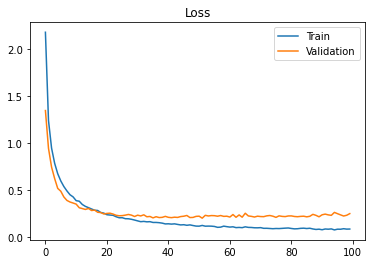

In [25]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

- Display **accuracy** curves:

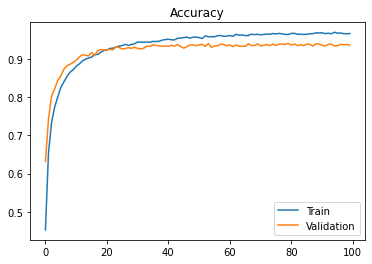

In [26]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [27]:
test_loss, test_acc = model.evaluate(X_val, y_val, batch_size = 128)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

20/20 [==============================] - 0s 2ms/step - loss: 0.2470 - accuracy: 0.9371
The test loss is:  0.24700121581554413
The best accuracy is:  93.71269345283508


## Step 7 - Make predictions on test data

To test your model and predict which classes new sounds belong to, you can import sounds into a `/workspace/data_test` folder. 

Here we are testing **2 new sounds**.

### 1. Test data preprocessing

To test your model, preprocessing of data is also required.

- Define columns name:

In [28]:
# header => for test data, we remove the columns "filename" and "label"
header_test = "filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean \
        spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var harmony_mean harmony_var perceptr_mean perceptr_var tempo mfcc1_mean mfcc1_var mfcc2_mean \
        mfcc2_var mfcc3_mean mfcc3_var mfcc4_mean mfcc4_var".split()

- Create the `data_test.csv` file:

In [29]:
file = open('data_test.csv', 'w', newline = '')
with file:
    writer = csv.writer(file)
    writer.writerow(header_test)

- Transform each `.wav` file into a `.csv` row:

In [30]:
for filename in os.listdir(f"/workspace/data_test/"):
    sound_name = f"/workspace/data_test/{filename}"
    y, sr = librosa.load(sound_name, mono = True, duration = 30)
    chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
    rmse = librosa.feature.rms(y = y)
    spec_cent = librosa.feature.spectral_centroid(y = y, sr = sr)
    spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr)
    rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y = y, sr = sr)
    to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'

    for e in mfcc:
        to_append += f' {np.mean(e)}'

    file = open('data_test.csv', 'a', newline = '')

    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

- Display the `data_test.csv` file:

In [31]:
df_test = pd.read_csv('data_test.csv')
df_test.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var
0,6602600A.wav,0.656396,0.025951,4411.566976,3075.282954,8271.979980,0.259399,-175.586517,15.836748,-27.523279,...,-14.992861,-4.541786,-2.174277,-2.991453,-6.129163,4.430593,-2.030360,9.661772,-3.305720,5.885292
1,6102604Z.wav,0.469673,0.038817,4848.347067,3054.492154,8407.998047,0.318465,-255.957214,20.976429,46.376137,...,5.709771,10.110609,5.456663,8.395433,2.099252,5.874355,-0.283402,8.174497,-2.389369,5.373516


In [32]:
X_test = scaler.transform(np.array(df_test.iloc[:, 1:27]))
print("X_test:", X_test)

X_test: [[ 0.87399814 -0.22887873  0.7265539   0.82018974  0.86664681  0.38757922
   0.96253597 -0.3671687  -0.15872006 -1.48121403 -1.26496944 -1.97982522
  -1.32980794 -2.27649888 -2.43205961 -1.578073   -1.47399312 -1.4091674
  -0.20358724 -0.97864963 -0.84587656  0.13346815 -0.17474253  1.14479029
  -0.13283243  0.31884033]
 [-0.41961721  0.10916723  0.99127725  0.79654714  0.91679682  0.77246417
   0.34283519 -0.30911742  1.43308272 -0.10953395  0.49787943  0.43427358
   0.18158367  0.89052257  0.40471913  0.79784617  0.81624608  0.50520179
   0.86459356  0.62363264  0.42801671  0.34396166  0.15470276  0.86845716
   0.04897824  0.22326655]]


### 2. Predictions

In [33]:
# generate predictions for samples
predictions = model.predict(X_test)
print(predictions)

[[1.0846043e-09 1.6415649e-12 9.4890416e-09 9.2322932e-14 1.3310787e-06
  1.1817685e-08 2.0763462e-10 1.6751633e-03 2.9351121e-14 1.0273402e-07
  4.3641804e-10 6.1153387e-14 6.3630665e-08 3.5445959e-07 2.5827596e-13
  1.4810501e-10 1.0730739e-07 6.8262551e-10 9.5866821e-12 1.1389738e-08
  1.2777201e-13 2.5086975e-13 2.3446211e-16 2.0129916e-08 1.3050463e-11
  4.5395640e-13 1.3146721e-15 1.8735930e-08 5.1956872e-10 2.3836957e-10
  7.7377023e-05 2.1344215e-10 1.0052622e-11 6.1082633e-10 2.2988610e-15
  1.8820338e-13 9.5173904e-09 1.6467880e-10 8.4483850e-11 9.0880079e-08
  1.9777625e-07 2.3848279e-14 9.5694134e-07 1.8911160e-13 9.9824405e-01]
 [9.9998140e-01 7.1613232e-12 7.3106021e-10 6.5697892e-10 3.1313073e-07
  7.5749123e-15 2.6435200e-11 1.5578937e-12 1.1175336e-12 1.2402628e-05
  8.4028717e-10 7.7341645e-07 6.9097314e-07 3.2675619e-08 5.1134511e-15
  3.9393536e-10 4.7269605e-11 3.1472491e-11 1.1956554e-07 1.2810980e-11
  1.1277454e-12 6.0293112e-12 5.9879478e-13 4.5765021e-16 1.182

In [34]:
# generate argmax for predictions
classes = np.argmax(predictions, axis = 1)
print(classes)

[44  0]


In [35]:
# transform classes number into classes name
result = encoder.inverse_transform(classes)
print(result)

['SpermWhale' 'AtlanticSpottedDolphin']


## Step 8 - Save the model for future inference

> To save your model, you should create an other Object Storage container (with write rights) and mount it in your workspace (`saved_model` in this example).

You can now save your model in a dedicated folder.

In [37]:
model.save('/workspace/saved_model/my_model')

INFO:tensorflow:Assets written to: /workspace/saved_model/my_model/assets


In [38]:
# my_model directory
%ls /workspace/saved_model/

my_model/


In [39]:
# contains an assets folder, saved_model.pb, and variables folder.
%ls /workspace/saved_model/my_model

assets/  saved_model.pb  variables/


In [40]:
model = tf.keras.models.load_model('/workspace/saved_model/my_model')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13824     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

## Conclusion

The accuracy of the model can be improved by increasing the number of epochs, but after a certain period we reach a threshold, so the value should be determined accordingly.

The accuracy obtained for the test set is **93.71 %**, which is a satisfactory result.

#### *I hope you have enjoyed this tutorial. Try for yourself!*